<a href="https://colab.research.google.com/github/Jabaananth/Brain-Tumor-MRI-Image-Classification/blob/main/Brain_Tumor_MRI_Image_Classification_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports Libraries and Tools

In [3]:
!pip install tensorflow

In [11]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

# Load Datasets

In [12]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/Tumour-20250726T062411Z-1-001/Tumour/test'
test_dir = '/content/drive/MyDrive/Tumour-20250726T062411Z-1-001/Tumour/train'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Visualization

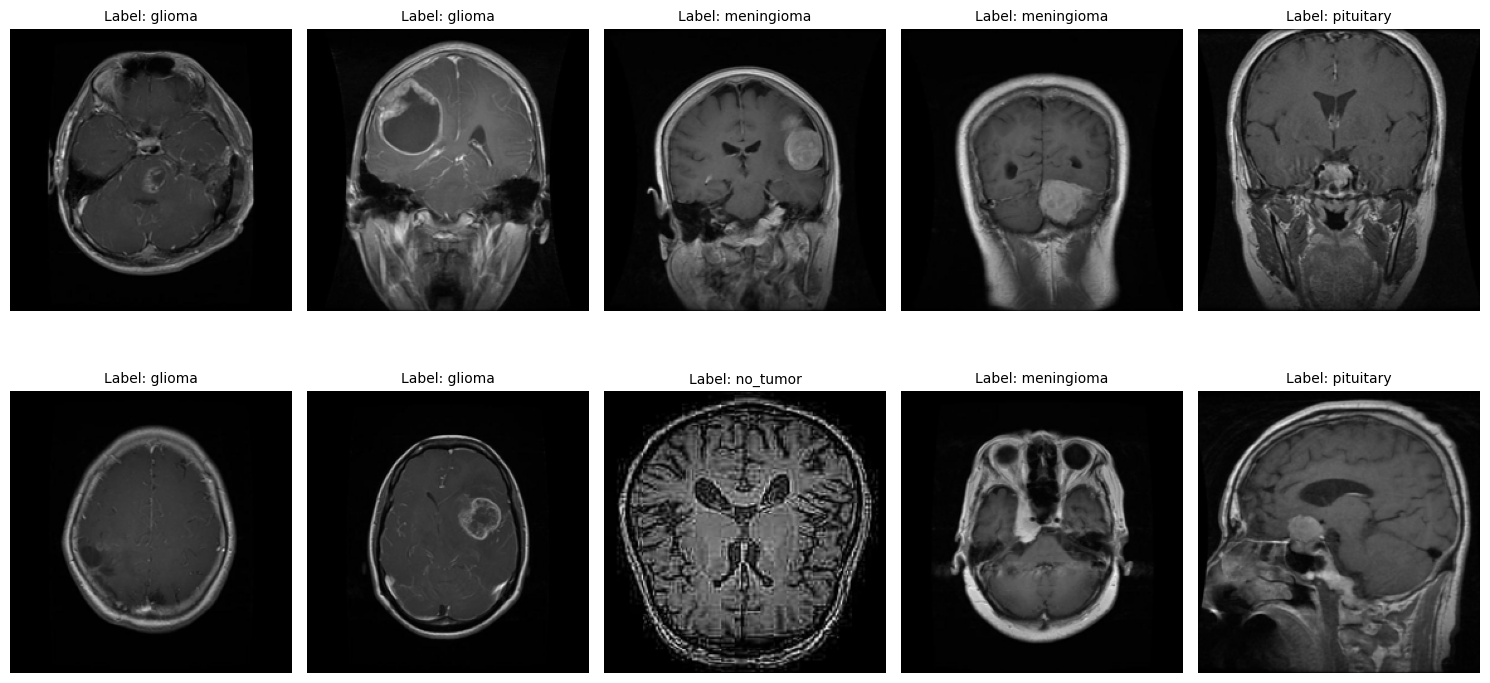

In [13]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


# Image Preprocessing (Helper Functions)

In [14]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

# VGG16 is a convolutional neural network (CNN) architecture, notable for its simplicity and effectiveness in image classification tasks. It was developed by researchers at Oxford University's Visual Geometry Group (VGG) and achieved high accuracy in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2014


In [15]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 1.4019 - sparse_categorical_accuracy: 0.3716
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 0.7621 - sparse_categorical_accuracy: 0.6665
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 0.5255 - sparse_categorical_accuracy: 0.7900
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 0.4020 - sparse_categorical_accuracy: 0.8559
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 0.3896 - sparse_categorical_accuracy: 0.8429


# Train and Val Plots

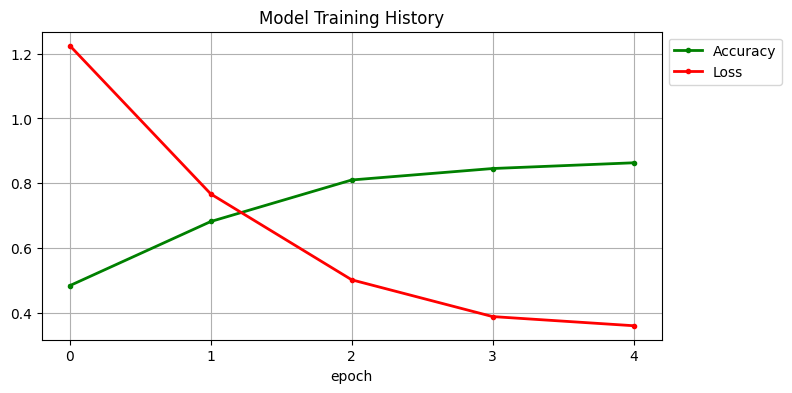

In [16]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Model Classification Report

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


53/53 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       335
           1       0.91      0.86      0.89       438
           2       0.98      0.75      0.85       564
           3       0.58      0.79      0.67       358

    accuracy                           0.81      1695
   macro avg       0.82      0.82      0.81      1695
weighted avg       0.85      0.81      0.82      1695



# Model Confusion Plot

Confusion Matrix:
[[297   8   2  28]
 [  7 378   0  53]
 [ 16   1 423 124]
 [ 42  29   5 282]]


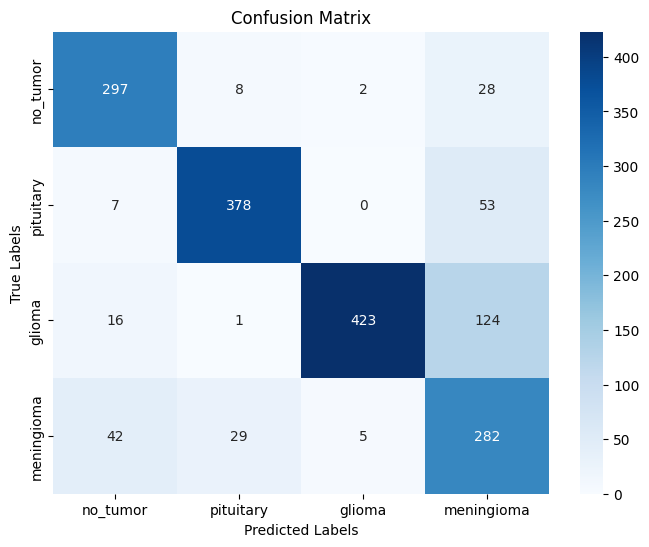

In [18]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Roc Curve Plot


In [31]:
from sklearn.preprocessing import label_binarize


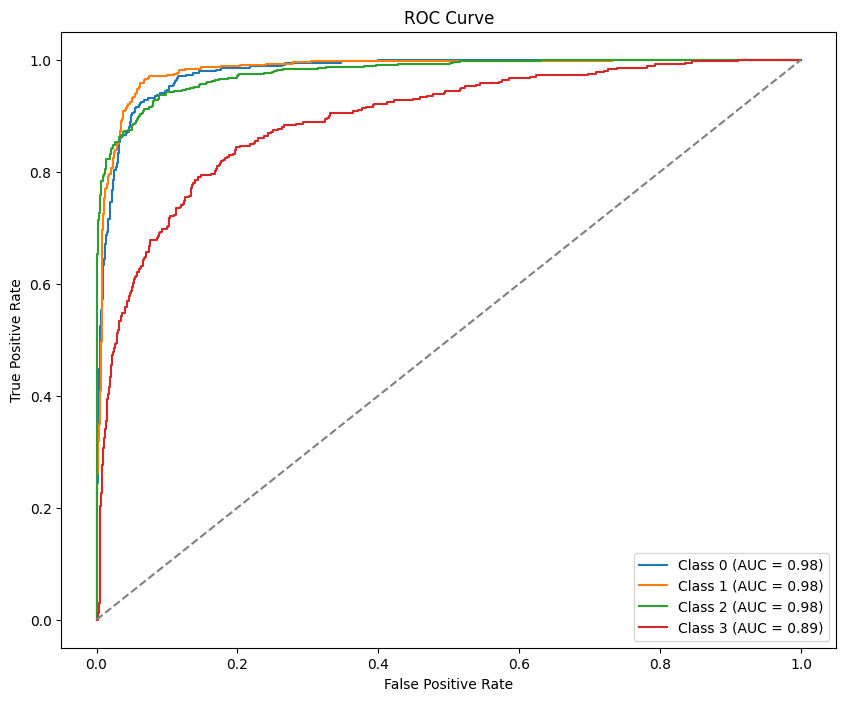

In [32]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Save & Load Model

In [33]:
import pickle as pkl
with open("/content/drive/MyDrive/Colab Notebooks/tumour_model.pkl", "wb") as f:
    pkl.dump(model, f)

In [34]:
with open("/content/drive/MyDrive/Colab Notebookslabel_encoder.pkl", "wb") as f:
    pkl.dump(history, f)

# MRI Tumor Detection System

In [37]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Class labels
labels_name = ['glioma', 'pituitary', 'notumor', 'meningioma']


le = LabelEncoder() # Initialize encoder
class_labels = le.fit_transform(labels_name)


def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


In [38]:
with open('/content/drive/MyDrive/Colab Notebooks/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


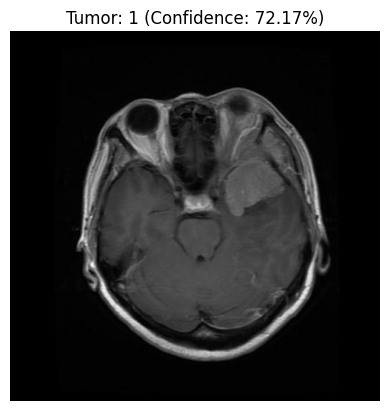

In [39]:
# Example usage
image_path = '/content/drive/MyDrive/Tumour-20250726T062411Z-1-001/Tumour/train/meningioma/Tr-me_0029_jpg.rf.b08172c682fc83833de525b4143c2dd8.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


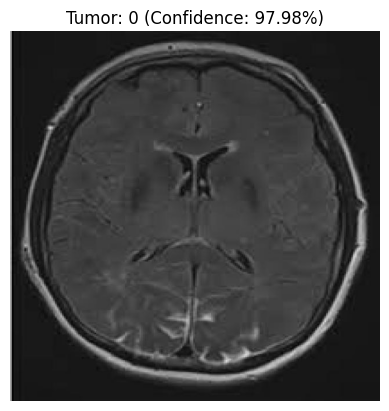

In [40]:

# Example usage
image_path = '/content/drive/MyDrive/Tumour-20250726T062411Z-1-001/Tumour/train/no_tumor/Tr-no_0020_jpg.rf.f4b92e9a9e19cb5492f57f97e316dee8.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


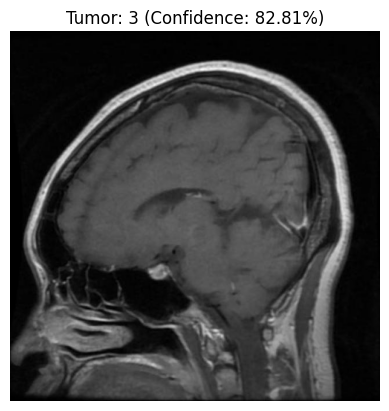

In [41]:
# Example usage
image_path = '/content/drive/MyDrive/Tumour-20250726T062411Z-1-001/Tumour/train/pituitary/Tr-pi_0081_jpg.rf.36295d12d60296038d9193f0cff05432.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


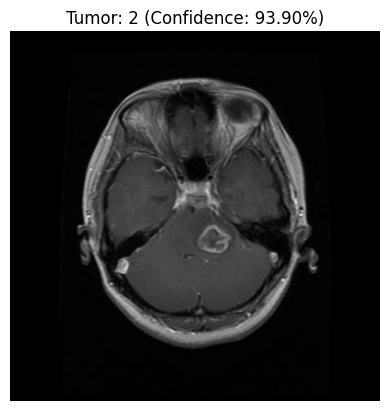

In [42]:
# Example usage
image_path = '/content/drive/MyDrive/Tumour-20250726T062411Z-1-001/Tumour/train/glioma/Tr-gl_0078_jpg.rf.eabc2d473e3c783e6a50e5af730e793e.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

In [43]:
!pip install streamlit streamlit_option_menu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.3/829.3 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.8 MB/s eta 0:00:00


In [60]:
%%writefile app.py

import pickle
import streamlit as st
import pandas as pd
from streamlit_option_menu import option_menu
import numpy as np
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import img_to_array

# Load models
with open('/content/drive/MyDrive/Colab Notebooks/tumour_model.pkl', 'rb') as f:
    base_model = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)


# Class labels
labels_name = ['glioma', 'pituitary', 'notumor', 'meningioma']


le = LabelEncoder() # Initialize encoder
class_labels = le.fit_transform(labels_name)

# Helper function to predict tumor type
def predict_tumor(image):
    IMAGE_SIZE = 128
    img = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)

    predictions = base_model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    confidence_score = np.max(predictions, axis=1)[0]

    predicted_label = le.inverse_transform([predicted_class_index])[0]

    if predicted_label == 'notumor':
        return "No Tumor", confidence_score
    else:
        return f"Tumor: {predicted_label}", confidence_score

# def predict_tumor(image):
#     IMAGE_SIZE = 128
#     img = image.resize((IMAGE_SIZE, IMAGE_SIZE))
#     img_array = img_to_array(img) / 255.0  # Normalize
#     img_array = np.expand_dims(img_array, axis=0)

#     predictions = model.predict(img_array)
#     predicted_class_index = np.argmax(predictions, axis=1)[0]
#     confidence_score = np.max(predictions, axis=1)[0]

#     if class_labels[predicted_class_index] == 'notumor':
#         return "No Tumor", confidence_score
#     else:
#         return f"Tumor: {class_labels[predicted_class_index]}", confidence_score

# Streamlit UI
st.set_page_config(page_title="Brain Tumor Classifier", layout="centered")
st.title("🧠 Brain Tumor Classification")

uploaded_file = st.file_uploader("Upload an MRI image", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    # Display image
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded MRI Image", use_container_width=True)

    # Predict button
    if st.button("Predict"):
        result, confidence = predict_tumor(image)
        st.success(f"Prediction: {result}")
        st.info(f"Confidence: {confidence*100:.2f}%")



Overwriting app.py


In [61]:
!wget -q -O - ipv4.icanhazip.com

35.238.98.186


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501

⠙

⠹⠸⠼⠴⠦⠧
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.238.98.186:8501

⠇⠏⠋your url is: https://fancy-dingos-read.loca.lt
2025-07-29 07:45:30.190969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753775130.223708   18096 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753775130.233224   18096 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-29 07:45:34.076392: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
1/1 ━━━━━━━━━━━━━━━━━━